In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
DATA_PATH = os.path.join("..", "data", "a2", "data")
TRAIN_PATH = os.path.join(DATA_PATH, "train")
TEST_PATH = os.path.join(DATA_PATH, "test")
FOLDERS = os.listdir(TRAIN_PATH)

In [3]:
DATASET = []

for folder in FOLDERS:
    for file in os.listdir(os.path.join(TRAIN_PATH, folder)):
        DATASET.append({"label": folder, "img_name": file})

DATASET = np.array(DATASET)
DATASET.shape

(1500,)

In [4]:
def get_data(dataset, img_size=(32, 32), path=TRAIN_PATH):
    X = []
    y = []
    for data in dataset:
        img = cv2.imread(os.path.join(path, data["label"], data["img_name"]))
        img = cv2.resize(img, img_size)
        X.append(img.flatten())
        y.append(data["label"])
    return np.array(X), np.array(y)

In [5]:
X, y = get_data(DATASET, img_size=(128, 128), path=TRAIN_PATH)
X.shape, y.shape

((1500, 49152), (1500,))

In [6]:
from skimage.feature import hog


def get_hog_features(X):
    hog_features = []
    for img in tqdm(X):
        fd, _ = hog(
            img.reshape((128, 128, 3)),
            orientations=8,
            pixels_per_cell=(16, 16),
            cells_per_block=(1, 1),
            visualize=True,
            channel_axis=-1,
        )
        hog_features.append(fd)
    return np.array(hog_features)

In [7]:
X_hog = get_hog_features(X)
X_hog.shape

100%|██████████| 1500/1500 [00:30<00:00, 48.46it/s]


(1500, 512)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_hog, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1200, 512), (300, 512), (1200,), (300,))

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [30]:
# Use grid search to find the best parameters
param_grid = {
    "C": [0.1, 1, 10, 100, 1000],
    "gamma": [1, 0.1, 0.01, 0.001, 0.0001, "scale", "auto"],
    "kernel": ["rbf", "poly", "sigmoid", "linear"],
}

In [31]:
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3, cv=5, n_jobs=-1)
res = grid.fit(X_train, y_train)

Fitting 5 folds for each of 140 candidates, totalling 700 fits


In [37]:
grid.best_params_, grid.best_estimator_, grid.best_score_

({'C': 10, 'gamma': 0.001, 'kernel': 'rbf'},
 SVC(C=10, gamma=0.001),
 0.5508333333333335)

In [33]:
import pandas as pd

df = pd.DataFrame(res.cv_results_)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.397886,0.032348,0.140792,0.011340,0.1,1,rbf,"{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}",0.120833,0.112500,0.116667,0.125000,0.133333,0.121667,0.007169,123
1,0.312065,0.022433,0.043998,0.006033,0.1,1,poly,"{'C': 0.1, 'gamma': 1, 'kernel': 'poly'}",0.225000,0.270833,0.262500,0.283333,0.291667,0.266667,0.023124,77
2,0.184423,0.020241,0.040601,0.004364,0.1,1,sigmoid,"{'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}",0.204167,0.154167,0.216667,0.204167,0.187500,0.193333,0.021667,109
3,0.192200,0.019215,0.037397,0.003137,0.1,1,linear,"{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}",0.525000,0.491667,0.545833,0.500000,0.520833,0.516667,0.019185,18
4,0.307800,0.027272,0.110709,0.003638,0.1,0.1,rbf,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}",0.079167,0.070833,0.075000,0.070833,0.079167,0.075000,0.003727,140


In [34]:
df.describe()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,0.237833,0.011022,0.060776,0.005714,0.350923,0.338006,0.364107,0.348036,0.362202,0.352655,0.018448,65.078571
std,0.068958,0.009161,0.041098,0.006647,0.168687,0.160761,0.178972,0.162448,0.164634,0.166355,0.006391,44.261334
min,0.089002,0.001745,0.018711,0.000490,0.079167,0.070833,0.075000,0.070833,0.079167,0.075000,0.003727,1.000000
25%,0.186157,0.004893,0.033747,0.002054,0.208333,0.198958,0.220833,0.207292,0.201042,0.205417,0.015264,18.000000
50%,0.250648,0.007891,0.038105,0.003510,0.347917,0.306250,0.343750,0.322917,0.370833,0.339167,0.019185,70.500000
75%,0.288777,0.012993,0.112742,0.006281,0.525000,0.491667,0.545833,0.500000,0.520833,0.516667,0.021842,105.250000
max,0.426467,0.057037,0.171799,0.048472,0.541667,0.558333,0.587500,0.550000,0.558333,0.550833,0.039878,140.000000


In [48]:
# Get the max score from the split*_test_score
df["split_score_max"] = df[["split{}_test_score".format(i) for i in range(5)]].max(axis=1)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split_score_max,split_score_mean
0,0.397886,0.032348,0.140792,0.011340,0.1,1,rbf,"{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}",0.120833,0.112500,0.116667,0.125000,0.133333,0.121667,0.007169,123,0.133333,0.121667
1,0.312065,0.022433,0.043998,0.006033,0.1,1,poly,"{'C': 0.1, 'gamma': 1, 'kernel': 'poly'}",0.225000,0.270833,0.262500,0.283333,0.291667,0.266667,0.023124,77,0.291667,0.266667
2,0.184423,0.020241,0.040601,0.004364,0.1,1,sigmoid,"{'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}",0.204167,0.154167,0.216667,0.204167,0.187500,0.193333,0.021667,109,0.216667,0.193333
3,0.192200,0.019215,0.037397,0.003137,0.1,1,linear,"{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}",0.525000,0.491667,0.545833,0.500000,0.520833,0.516667,0.019185,18,0.545833,0.516667
4,0.307800,0.027272,0.110709,0.003638,0.1,0.1,rbf,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}",0.079167,0.070833,0.075000,0.070833,0.079167,0.075000,0.003727,140,0.079167,0.075000


In [47]:
# Get the max score from the split*_test_score
df["split_score_mean"] = df[["split{}_test_score".format(i) for i in range(5)]].mean(axis=1)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split_score_max,split_score_mean
0,0.397886,0.032348,0.140792,0.011340,0.1,1,rbf,"{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}",0.120833,0.112500,0.116667,0.125000,0.133333,0.121667,0.007169,123,0.121667,0.121667
1,0.312065,0.022433,0.043998,0.006033,0.1,1,poly,"{'C': 0.1, 'gamma': 1, 'kernel': 'poly'}",0.225000,0.270833,0.262500,0.283333,0.291667,0.266667,0.023124,77,0.266667,0.266667
2,0.184423,0.020241,0.040601,0.004364,0.1,1,sigmoid,"{'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}",0.204167,0.154167,0.216667,0.204167,0.187500,0.193333,0.021667,109,0.193333,0.193333
3,0.192200,0.019215,0.037397,0.003137,0.1,1,linear,"{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}",0.525000,0.491667,0.545833,0.500000,0.520833,0.516667,0.019185,18,0.516667,0.516667
4,0.307800,0.027272,0.110709,0.003638,0.1,0.1,rbf,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}",0.079167,0.070833,0.075000,0.070833,0.079167,0.075000,0.003727,140,0.075000,0.075000


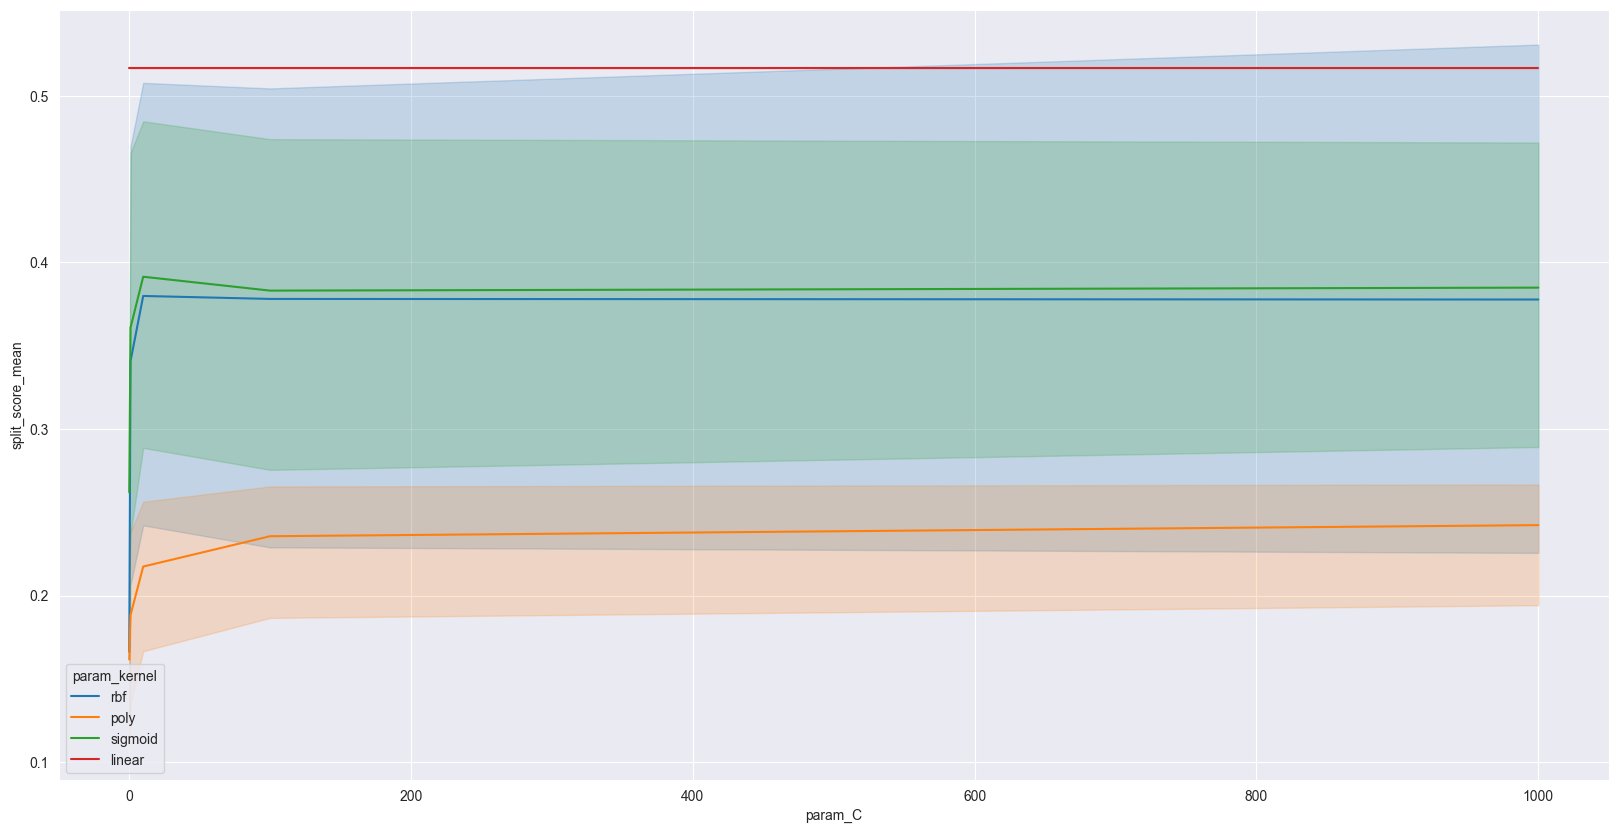

In [49]:
# Plot the mean score
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
plt.figure(figsize=(20, 10))
sns.lineplot(data=df, x="param_C", y="split_score_mean", hue="param_kernel")
plt.show()

In [45]:
# Get the max score from the split*_test_score
max_score = df["split_score_max"].max()
max_score

0.5875

<Axes: >

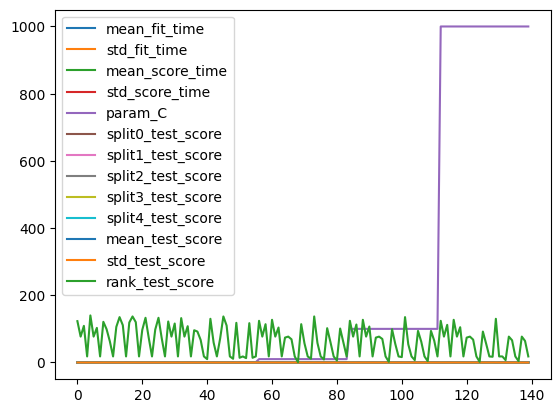

In [35]:
df.plot()